# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from skimage import io
from skimage.transform import rescale, resize
import datetime
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
rn.seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
root_path = '/home/datasets/Project_data'
train_folder = root_path + '/train'
val_folder = root_path + '/val'
train_doc = np.random.permutation(open(root_path + '/train.csv').readlines())
val_doc = np.random.permutation(open(root_path + '/val.csv').readlines())
batch_size = 32


In [4]:
enable_augmentation = False 
seq_idx = range(7,26,2)

dim_x, dim_y = 120, 120

In [5]:
datagen = ImageDataGenerator(
    brightness_range=[0.2,1.0],
	rotation_range=15,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	fill_mode="nearest")

In [6]:
# Helper method to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [7]:
def crop_image(image):
     if image.shape[1] > image.shape[0]:
        diff_px = image.shape[1] - image.shape[0]
        crop_start = diff_px//2
        crop_end = crop_start + image.shape[0]
        image = image[:, crop_start:crop_end]
     elif image.shape[0] > image.shape[1]:
        diff_px = image.shape[0] - image.shape[1]
        crop_start = diff_px//2
        crop_end = crop_start + image.shape[1]
        image = image[:, crop_start:crop_end]

     return image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size, is_train = False, augmentation = False, debug=False):
    img_idx =  seq_idx 
    x = len(img_idx)
    y, z = dim_x, dim_y
    
    while True:
        if is_train and augmentation:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                if debug:
                    plt.figure(figsize=(20,5))
              
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) 
               
                for idx,item in enumerate(img_idx): 
                    filename = source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]

                    image = io.imread(filename).astype(np.float32)

                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))
       
                    image = crop_image(image=image)

                    resized_im = resize(image, output_shape=(120,120))
                
                    if augmentation==True and is_train==True:
                        resized_im = next(datagen.flow(np.expand_dims(resized_im, axis=0), batch_size=1))[0]
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im.astype('uint8'))

                    #Normalize images
                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels 


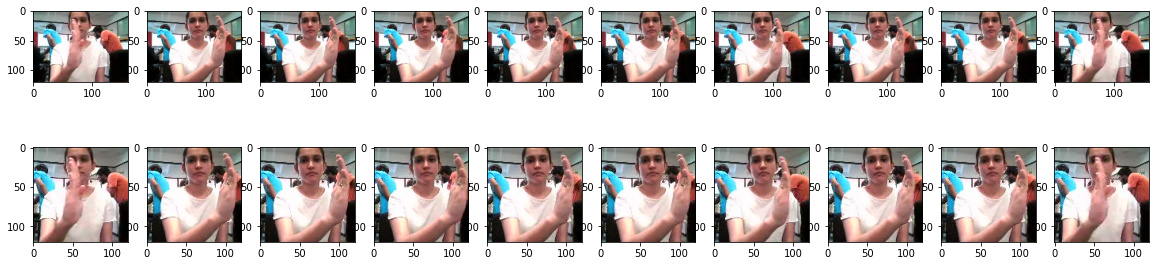

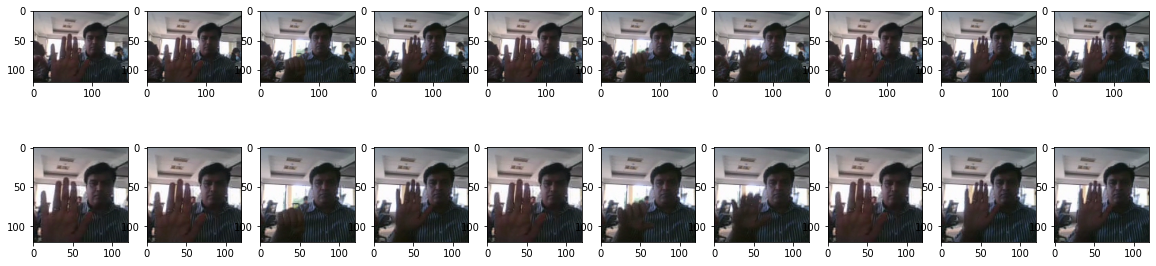

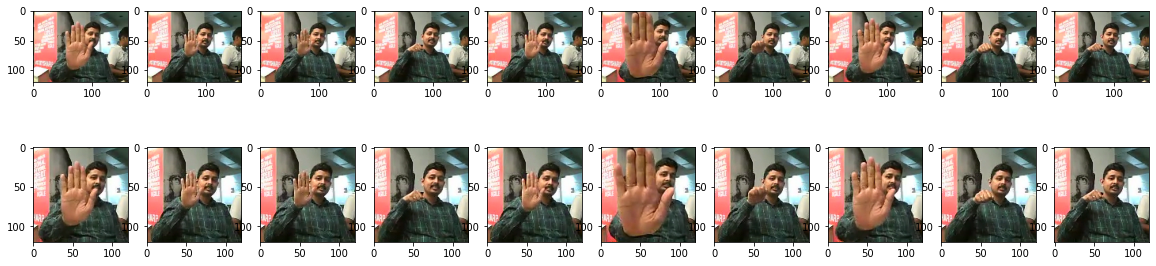

In [9]:
test_gen = generator(train_folder, train_doc, 3, is_train = True, augmentation=False, debug = True)

xx = next(test_gen)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = train_folder
val_path =  val_folder

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [12]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

2024-11-06 12:15:57.791577: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-06 12:15:57.791634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22855 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
#optimiser = optimizers.Adam(learning_rate=0.01)
optimiser = optimizers.Adam(lr=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 128)   0

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [15]:
model_name = 'model_init_exp_02' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30


2024-11-06 12:16:02.343384: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.8834 - categorical_accuracy: 0.3065
Epoch 00001: saving model to model_init_exp_02_2024-11-0612_15_57.081057/model-00001-2.88343-0.30655-4467.47217-0.17969.h5
21/21 [==============================] - 57s 3s/step - loss: 2.8834 - categorical_accuracy: 0.3065 - val_loss: 4467.4722 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4639 - categorical_accuracy: 0.4598
Epoch 00002: saving model to model_init_exp_02_2024-11-0612_15_57.081057/model-00002-1.46386-0.45982-742.85693-0.19531.h5
21/21 [==============================] - 51s 3s/step - loss: 1.4639 - categorical_accuracy: 0.4598 - val_loss: 742.8569 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.2906 - categorical_accuracy: 0.5074
Epoch 00003: saving model to model_init_exp_02_2024-11-0612_15_57.081057/model-00003-1.29063-0.50744-130.92398-

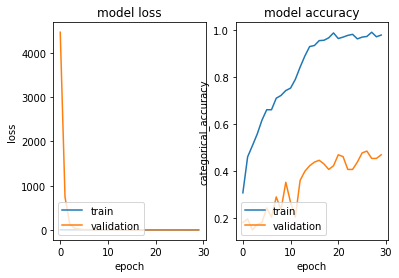

In [21]:
def plot_history(history):
    ax1 = plt.subplot(121)
    ax1 = plt.plot(history.history['loss'])
    ax1 = plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    ax2 = plt.subplot(122)
    ax2 = plt.plot(history.history['categorical_accuracy'])
    ax2 = plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')

plot_history(history)

In [19]:
### RNN + CNN

In [22]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [23]:
optimiser = optimizers.Adam(lr=0.01) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 10, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 10, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 10, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 114, 114, 8)      

In [24]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.3508 - categorical_accuracy: 0.3750
Epoch 00001: saving model to model_init_exp_02_2024-11-0612_15_57.081057/model-00001-1.35082-0.37500-1.26865-0.18750.h5
21/21 [==============================] - 54s 3s/step - loss: 1.3508 - categorical_accuracy: 0.3750 - val_loss: 1.2686 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.1300 - categorical_accuracy: 0.4643
Epoch 00002: saving model to model_init_exp_02_2024-11-0612_15_57.081057/model-00002-1.13004-0.46429-1.67677-0.14844.h5
21/21 [==============================] - 51s 3s/step - loss: 1.1300 - categorical_accuracy: 0.4643 - val_loss: 1.6768 - val_categorical_accuracy: 0.1484 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.0645 - categorical_accuracy: 0.5193
Epoch 00003: saving model to model_init_exp_02_2024-11-0612_15_57.081057/model-00003-1.06454-0.51935-1.73478-0

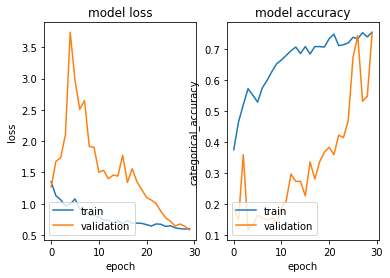

In [25]:
plot_history(history)